In [1]:
import functools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, kstest
from itertools import combinations

# sns.set_style("dark", {"grid.color": ".6", "grid.linestyle": ":"})
# sns.set_context("talk")
# sns.set(font_scale = 1.25)
plt.rcParams.update({'font.size': 12})

In [2]:
combo=2

In [3]:
meta_outfile = f"/data5/deepro/ukbiobank/analysis/lifestyle_factors/data/meta_rarecomb_out_{combo}.csv"
meta_infile = "/data5/deepro/ukbiobank/analysis/lifestyle_factors/data/meta_rarecomb_in.csv"
case_sample_file = "/data5/UK_Biobank/bmi_project/combinations/white_british/cases_controls/high_low_cases.txt"
variants_file = "/data5/UK_Biobank/annotations/vep/2022_03_13/data/variants_by_gene/lof_missense_pred_freq_0.01.tsv"
phenotypes_file = "/data5/UK_Biobank/bmi_project/combinations/all_combinations/sample_tables/white_british_samples_with_residuals.csv"
wes_file = "/data5/UK_Biobank/bmi_project/combinations/white_british/tables/wes.tsv"
lifestyle_factor_files = [
    "/data5/deepro/ukbiobank/analysis/lifestyle_factors/data/mental_health/cat_extremes.csv",
    "/data5/deepro/ukbiobank/analysis/lifestyle_factors/data/diet/cat_extremes.csv",
    "/data5/deepro/ukbiobank/analysis/lifestyle_factors/data/physical_activity/cat_extremes.csv"
]

# Combinations that were significant

In [4]:
rarecomb_out = pd.read_csv(meta_outfile)
rarecomb_out_sig = rarecomb_out.loc[rarecomb_out.Case_Adj_Pval_BH<0.05]

# Unique items (genes or lifestyle factors) that came out of that combination

In [5]:
enriched_combos = rarecomb_out_sig.loc[:, [f"Item_{c}" for c in range(1, combo+1)]].values

In [6]:
columns_to_use = sorted(set(enriched_combos.flatten()))

In [7]:
gene_columns_to_use = [c for c in columns_to_use if "_ENSG" in c]
lifestyle_columns_to_use = [c for c in columns_to_use if "_ENSG" not in c]

# Samples with these gene columns

In [8]:
wes_df = pd.read_csv(wes_file, sep="\t", low_memory=False, usecols=["Sample_Name"] + gene_columns_to_use, index_col=0)

# Samples with these lifestyle factors

In [9]:
lifestyle_df = pd.concat([pd.read_csv(lf, index_col=0) for lf in lifestyle_factor_files], axis=1).fillna(0.)

# BMI of these samples

In [10]:
phenotypes_df = pd.read_csv(phenotypes_file, low_memory=False, usecols=["eid", "bmi"], index_col=0, dtype={"eid": str, "bmi": np.float64})

In [11]:
gene_df = wes_df.merge(phenotypes_df, left_index=True, right_index=True)
profile_df = lifestyle_df.merge(gene_df, left_index=True, right_index=True)

# Filter samples based on conditions

The conditions are:
1. Samples who have any one of the genes but not the lifestyle factors
2. Samples who have any one of the lifestyle factors but not the genes
3. Samples who have these combinations identified by rarecomb
4. Samples who do not have either the gene of the lifestyle factors

In [12]:
# condition 1 eval string
cond1 = "(" + " | ".join([f"({gene} == 1)" for gene in gene_columns_to_use]) + ")" + " & " + "(" + " & ".join([f"({lf} == 0)" for lf in lifestyle_columns_to_use]) + ")"
# condition 2 eval string
cond2 = "(" + " | ".join([f"({lf} == 1)" for lf in lifestyle_columns_to_use]) + ")" + " & " + "(" +" & ".join([f"({gene} == 0)" for gene in gene_columns_to_use]) + ")"
# condition 3 eval string
cond3 = " | ".join(["(" + " & ".join([f"({c} == 1)" for c in ec_i]) + ")" for ec_i in enriched_combos])
# condition 4 eval string
cond4 = " & ".join([f"({lf_g} == 0)" for lf_g in columns_to_use])

# Creating dataframe for plotting

In [13]:
def create_plot_df(conds, cond_cats=["genes only", "lifestyles only", "combos", "no gene or lifestyle"]):
    plot_df = pd.DataFrame()
    for cond, condcat in zip(conds, cond_cats):
        pltdf = profile_df.loc[profile_df.eval(cond), "bmi"].to_frame()
        pltdf["category"] = condcat
        plot_df = pd.concat((plot_df, pltdf))
    return plot_df

In [14]:
plot_df = create_plot_df([cond1, cond2, cond3, cond4])

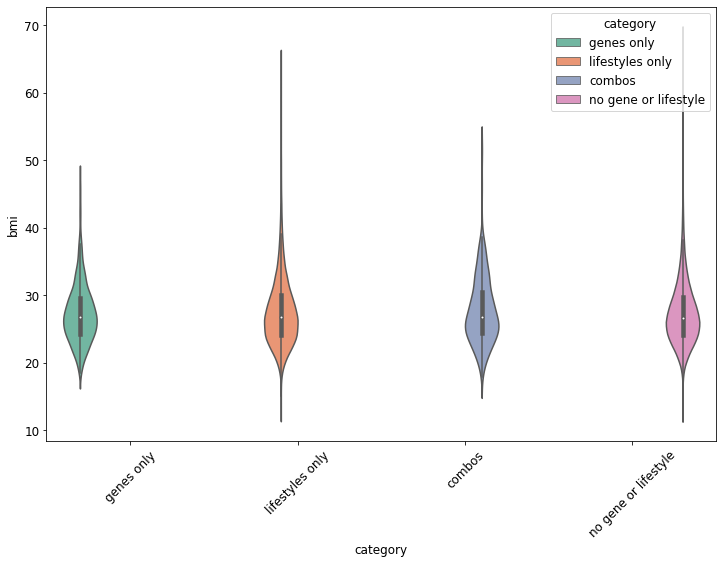

In [15]:
fig, axes = plt.subplots(figsize=(12,8))
sns.violinplot(
    data=plot_df, 
    x="category", 
    y="bmi", 
    hue="category", 
    palette="Set2", 
    orient="v",
    ax=axes,
    )
# sns.swarmplot(data=plot_df, x="category", y ="bmi", color=".25", ax=axes, orient="v")
plt.xticks(rotation=45);

# Significance test

In [16]:
combos_bmi = plot_df.loc[plot_df.category=="combos"].bmi.values
genes_only = plot_df.loc[plot_df.category=="genes only"].bmi.values
lifestyles_only = plot_df.loc[plot_df.category=="lifestyles only"].bmi.values
no_gene_or_lifestyle = plot_df.loc[plot_df.category=="no gene or lifestyle"].bmi.values

In [17]:
cond_cats=["genes only", "lifestyles only", "combos", "no gene or lifestyle"]

In [18]:
def run_test(cond1, cond2):
    x = plot_df.loc[plot_df.category==cond1].bmi.values
    y = plot_df.loc[plot_df.category==cond2].bmi.values
    ttest_res = ttest_ind(x, y)
    kstest_res = kstest(x, y)
    return f"{cond1} vs {cond2}", ttest_res.pvalue,  kstest_res.pvalue

In [19]:
pd.DataFrame([run_test(*c) for c in list(combinations(cond_cats, 2))], columns=["comparisons", "ttest_pvalue", "kstest_pvalue"]).sort_values("kstest_pvalue")

,comparisons,ttest_pvalue,kstest_pvalue
4,lifestyles only vs no gene or lifestyle,4.439228e-09,3.416045e-08
5,combos vs no gene or lifestyle,9.024123e-02,6.602068e-02
0,genes only vs lifestyles only,1.632479e-01,9.922389e-02
1,genes only vs combos,1.080036e-01,1.154364e-01
3,lifestyles only vs combos,3.831967e-01,3.412878e-01
2,genes only vs no gene or lifestyle,8.353689e-01,5.240838e-01


In [20]:
[np.mean(x) for x in [combos_bmi, genes_only, lifestyles_only, no_gene_or_lifestyle]]

[27.767502628968252, 27.30518050875454, 27.528107775990982, 27.335797255131343]

In [21]:
[len(x) for x in [combos_bmi, genes_only, lifestyles_only, no_gene_or_lifestyle]]

[336, 1009, 24252, 141045]

# Extend the significance table to make it make better sense

## Rearrange lifestyle and gene

- Add types to items (types can be either gene or lifestyle)
- Arrangement should be lifestyle first and gene second

In [36]:
relevant_columns = [
    "Item_1", 
    "Item_2",
    "Case_Obs_Count_Combo",
    "Case_Exp_Prob_Combo",
    "Case_Obs_Prob_Combo",
    "Case_pvalue_more",
    "Case_Adj_Pval_bonf",
    "Case_Adj_Pval_BH"
    ]

rarecomb_out_sig_filtered = rarecomb_out_sig.loc[:, relevant_columns]

In [37]:
rarecomb_out_sig_filtered["combo_num"] = list(range(1, len(rarecomb_out_sig_filtered)+1))
rarecomb_out_sig_filtered = rarecomb_out_sig_filtered.set_index("combo_num")

In [38]:
melted_df = pd.melt(rarecomb_out_sig_filtered.reset_index(), id_vars=["combo_num"], value_vars=["Item_1", "Item_2"])
melted_df["type"] = ["gene" if v.startswith("Input_ENSG") else "lifestyle" for v in melted_df.value.values]
melted_df_pivot = melted_df.sort_values(["type", "value"], ascending=False).groupby("combo_num").agg({"value": lambda x: ",".join(x), "type": lambda x: ",".join(x)})
melted_df_pivot_concat = pd.concat((melted_df_pivot.value.str.split(",", expand=True), melted_df_pivot.type.str.split(",", expand=True)), axis=1)
melted_df_pivot_concat.columns = [f"Item_{i}" for i in range(1, combo+1)] + [f"Item_{i}_type" for i in range(1, combo+1)]

In [40]:
rarecomb_out_sig_rearranged = rarecomb_out_sig_filtered.drop(columns=[f"Item_{i}" for i in range(1, combo+1)]).merge(melted_df_pivot_concat, left_index=True, right_index=True)

## Add gene symbols to items

In [42]:
filename = '/data5/bx_reference/hg38/annotations/gene_annotations/GENCODE39/gencode.v39.parsed.genes.tsv'
gencode = pd.read_csv(filename, sep='\t', low_memory=False)
gencode["gene_id_stripped"] = gencode["gene_id"].str.split(".", expand=True)[0]

In [43]:
gene_symbol_dict = dict(zip(gencode.gene_id_stripped, gencode.gene_name))

In [44]:
rarecomb_out_sig_rearranged["Item_1_symbol"] = rarecomb_out_sig_rearranged.apply(lambda row: gene_symbol_dict[row.Item_1.replace("Input_", "")] if row.Item_1.startswith("Input_ENSG") else np.nan, axis=1)
rarecomb_out_sig_rearranged["Item_2_symbol"] = rarecomb_out_sig_rearranged.apply(lambda row: gene_symbol_dict[row.Item_2.replace("Input_", "")] if row.Item_2.startswith("Input_ENSG") else np.nan, axis=1)

# Save table

In [46]:
rarecomb_out_sig_rearranged.to_csv("/data5/deepro/ukbiobank/analysis/lifestyle_factors/data/results/tables/combo2_lf_gene.csv")

# Add information about the variants and their frequency

In [47]:
# variants_df = pd.read_csv(variants_file, sep="\t", low_memory=False, usecols=["Sample", "variant_id", "Gene", "SYMBOL", "Mut_type"], dtype=str)